# FCNN (Fully Convolutional Neural Network)

Este tipo de arquitecturas son conformadas por dos bloques principales, que conforman una trayectoria de codificador-decodificador o una trayectoria expansiva de contracción equivalente. En la figura se observan estas dos etapas y se muestra un ejemplo de cómo las características extraídas se hacen más particulares o especificas a medida que se profundiza en la red.

Los codificadores-decodificadores pueden definirse así:

* **Codificador (parte izquierda de la red)**: Codifica la imagen en una representación abstracta de las características de la imagen aplicando una secuencia de bloques convolucionales que disminuyen gradualmente la altura y la anchura de la representación, pero un número creciente de canales que corresponden a las características de la imagen.

* **Decodificador (parte derecha de la red)**: Decodifica la representación de la imagen en una máscara binaria aplicando una secuencia de convoluciones ascendentes (NO es lo mismo que la deconvolución) que aumenta gradualmente la altura y la anchura de la representación hasta el tamaño de la imagen original y disminuye el número de canales hasta el número de clases que estamos segmentando.


<div style="width:100%;text-align: center;">
<img src="https://i.imgur.com/WNCNVHS.png" width="800" height="400"/>
</div>

La FCNN es la arquitectura más utilizada para la segmentación de imágenes, entre ellas, se utiliza una en particular para imagenes médicas y se conoce como red U-net la cual tiene conexiones entre los dos bloques principales con el fin de aportar información a la etapa de reconstrucción del mapa de características.

# Objetivo de las redes U-Net
U-Net es una arquitectura de red convolucional para la segmentación rápida y precisa de imágenes. La intención de U-Net es captar tanto las características del contexto como las de la ubicación. La idea principal de la aplicación es utilizar capas de contracción sucesivas, a las que siguen inmediatamente operadores de remuestreo para obtener salidas de mayor resolución en las imágenes de entrada. 
# Arquitectura UNET
  

<div>
<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" width="900" height="800"/>
</div>


Al visualizar la forma de la arquitectura de la red, podemos ver por qué probablemente se llama U-Net. La arquitectura tiene forma de U, de ahí su nombre. La arquitectura de la red se ilustra en la figura anterior. Consta de una vía de contracción (lado izquierdo) y una vía de expansión (lado derecho) al igual que las FCNN y además contiene la conexión entre los dos bloque como se mencionó anteriormente. La ruta de contracción sigue la arquitectura típica de una red convolucional (CNN).

# Database para aplicar modelo U-net
La base de datos utilizada consiste en 800 imágenes de radiografía de tórax donde 394 imágenes corresponden a una manifestación de tuberculosis y 406 corresponden a radigrafías normales o de personas sanas. Esta base de datos es una combinación de dos bases de datos conocidas en el estado del arte para radiografía de tórax (Montgomery y Shenzen database).

## Etapas de pre-procesamiento y entrenamiento
1. Cargar la base de datos
2. Preparación de los datos
3. Imágenes de entrenamiento y de prueba
4. Construyendo una red U-net
5. Entrenamiento del modelo U-net
6. Métricas y validacón

# Configuración

In [2]:
import numpy as np 
import pandas as pd 
import tensorflow as tf # Libreria para aprendizaje automático
import os
import re 

from PIL import Image # Librería de edición de imágenes
from tqdm import tqdm # librería para monitorear las funciones y sus tiempos de ejecución.
import cv2 # Librería Open-CV para python.

from skimage import segmentation
from glob import glob
from collections import defaultdict # Define un diccionario
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
sns.set(font_scale = 2)

from ipywidgets import interact

## 1. Cargar la base de datos 

Sobre los datos:
* Hay una pequeña anormalidad en la convención de nombres de las máscaras.
* Algunas imágenes no tienen sus correspondientes máscaras.

Comprobación de las radiografías y sus respectivas máscaras

In [3]:
# Declarando los directorios de las imágenes
DIR = "data/"

lung_image_paths = glob(os.path.join(DIR,"Lung Segmentation/CXR_png/*.png")) # Directorio de las imagenes radiográficas.
mask_image_paths = glob(os.path.join(DIR,"Lung Segmentation/masks/*.png")) # Directorio de las máscaras, que indican la localización de pulmones.

related_paths = defaultdict(list)

# Combinando las imágenes de 1 para 1
for img_path in lung_image_paths:
    img_match = re.search("CXR_png/(.*)\.png$", img_path)
    if img_match:
        img_name = img_match.group(1)
    for mask_path in mask_image_paths:
        mask_match = re.search(img_name, mask_path)
        if mask_match:
            related_paths["image_path"].append(img_path)
            related_paths["mask_path"].append(mask_path)

paths_df = pd.DataFrame.from_dict(related_paths)
paths_df.head()

,image_path,mask_path
0,data/Lung Segmentation/CXR_png/MCUCXR_0023_0.png,data/Lung Segmentation/masks/MCUCXR_0023_0.png
1,data/Lung Segmentation/CXR_png/CHNCXR_0286_0.png,data/Lung Segmentation/masks/CHNCXR_0286_0_mas...
2,data/Lung Segmentation/CXR_png/CHNCXR_0022_0.png,data/Lung Segmentation/masks/CHNCXR_0022_0_mas...
3,data/Lung Segmentation/CXR_png/CHNCXR_0067_0.png,data/Lung Segmentation/masks/CHNCXR_0067_0_mas...
4,data/Lung Segmentation/CXR_png/CHNCXR_0572_1.png,data/Lung Segmentation/masks/CHNCXR_0572_1_mas...


In [4]:
Nimgs = paths_df.shape[0] # Número total de imagenes
@interact(xray_num = (0,Nimgs-1,1))
def plot_pair_img_mask(xray_num):
    img_path = paths_df["image_path"][xray_num]
    mask_path = paths_df["mask_path"][xray_num]

    img = Image.open(img_path)
    mask = Image.open(mask_path)
    
 ## Visualizar imagen e independientemente su máscara
    fig = plt.figure(figsize = (10,10))

    ax1 = fig.add_subplot(2,2,1)
    ax1.imshow(img, cmap = "gray")
    plt.title("Original");
    plt.axis('off')
    
    ax2 = fig.add_subplot(2,2,2)
    plt.axis('off')
    ax2.imshow(mask, cmap = "viridis")
    plt.title("Máscara real");
    fig.show()

    plt.figure(figsize = (5,5))
    plt.imshow(img, cmap = "gray")
    edges_est = segmentation.clear_border(np.squeeze(mask))
    plt.contour(edges_est,[0.5],colors=['red'])
    plt.axis('off')
    plt.show()

interactive(children=(IntSlider(value=351, description='xray_num', max=703), Output()), _dom_classes=('widget-…

## 2. Preparación de los datos  
En este paso crearemos una función para tratar las imágenes de rayos X y las máscaras. Este proceso es necesario para poder preprocesar y normalizar las imágenes.  
Utilizaremos la biblioteca `cv2` para redimensionar las imágenes y las máscaras.

In [19]:
img_side_size = 256 # tamaño de las imágenes a procesar.

def prepare_train_test(df = pd.DataFrame(), resize_shape = tuple(), color_mode = "rgb"):
    img_array = list()
    mask_array = list()

    # Preparando Imagenes
    for image_path in tqdm(paths_df.image_path):
        resized_image = cv2.resize(cv2.imread(image_path),resize_shape) # Reescalando las imagenes a una resolución dada por el parámetro resize_shape
        resized_image = resized_image/255. # Normalizamos las intensidades de la imágen a valores entre 0 y 1. 
        # Procesar según el tipo de imagen (Color --> RGB | escala de grises --> Gray)
        if color_mode == "gray":
            img_array.append(resized_image[:,:,0])
        elif color_mode == "rgb":
            img_array.append(resized_image[:,:,:])
            
    # Preparando las mascaras
    for mask_path in tqdm(paths_df.mask_path):
        resized_mask = cv2.resize(cv2.imread(mask_path),resize_shape)
        resized_mask = resized_mask/255.
        mask_array.append(resized_mask[:,:,0])

    return img_array, mask_array

img_array, mask_array = prepare_train_test(df = paths_df, resize_shape = (img_side_size,img_side_size), color_mode = "gray")

100%|██████████| 704/704 [00:44<00:00, 15.89it/s]


## 3. Imágenes de entrenamiento y de prueba
Separación de los datos de entrenamiento y de prueba

In [20]:
from sklearn.model_selection import train_test_split # Función para separar el conjunto de entrenamiento y de test.
img_train, img_test, mask_train, mask_test = train_test_split(img_array, mask_array, test_size = 0.2, random_state= 42)

# Se realiza un reshape para asegurar la forma del tensor adecuada: #img x W x H x C | donde W es el ancho de las imagenes, H es el alto y C el número de canales (gray C=1, RGB C=3)

img_train = np.array(img_train).reshape(len(img_train), img_side_size, img_side_size, 1)
img_test = np.array(img_test).reshape(len(img_test), img_side_size, img_side_size, 1)
mask_train = np.array(mask_train).reshape(len(mask_train), img_side_size, img_side_size, 1)
mask_test = np.array(mask_test).reshape(len(mask_test), img_side_size, img_side_size, 1)

## 4. Construyendo una red U-net

* Las métricas utilizadas para evaluar los resultados son el coeficiente Dice e IoU (Intersection over Union):

<div style="width:100%;text-align: center;">
<img src="https://www.researchgate.net/publication/328671987/figure/fig4/AS:688210103529478@1541093483784/Calculation-of-the-Dice-similarity-coefficient-The-deformed-contour-of-the-liver-from.ppm" width="500" height="300"/>
</div>

<div style="width:100%;text-align: center;">
<img src="https://i.imgur.com/yJp0n0n.png" width="500" height="300"/>
</div>

In [21]:
# Función que calcula la medida Dice 
def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

# Función que calcula la pérdida según el Dice.
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

# Función Dice para test
def dice_coef_test(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    union = np.sum(y_true_f) + np.sum(y_pred_f)
    if union==0: return 1
    intersection = np.sum(y_true_f * y_pred_f)
    return 2. * intersection / union

# Intersection over Union metric
def IOU(y_true,y_pred):
    intersection = np.sum(y_true * y_pred)
    sum_ = np.sum(y_true) + np.sum(y_pred)
    jac = (intersection + 1) / (sum_ - intersection + 1)
    return jac

* Conv2D: Para crear las capas de convolución 2D, utilizaremos los siguientes filtros = [32, 64, 256 y 512]. Esta capa crea un núcleo de convolución que ayuda a producir un tensor de salida.

In [22]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.activations import *
from tensorflow.keras.optimizers import Adam


def unet(input_size=(img_side_size,img_side_size,1)):
    inputs = Input(input_size)
    """
    codifica la imagen en una representación abstracta de las características de la imagen aplicando 
    una secuencia de bloques convolucionales que disminuyen gradualmente la altura y la anchura de la representación
    """
    # codificador (parte izquierda de la “U”)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    """
    decodifica la representación de la imagen en una máscara binaria aplicando una secuencia de convoluciones ascendentes.
    que aumenta gradualmente la altura y la anchura de la representación hasta el tamaño de la imagen original y disminuye el número de 
    de canales al número de clases que estamos segmentando
    """
    # decodificador (parte derecha de la “U”)
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    
    #
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [ ]:
classical_model = unet(input_size=(img_side_size,img_side_size,1)) # Creamos el modelo Clásico


# **Hybrid Unet Classical encoder - Quantum decoder**

In [14]:
IBM_TOKEN = 'XXXXX'

**Q-node as a layer Conv in 2D:**

In [11]:
!python --version

Python 3.9.16


In [ ]:
%pip install pennylane==0.30.0

In [ ]:
%pip install pennylane-qiskit

In [109]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
# Enable eager execution
tf.config.run_functions_eagerly(True)
from tensorflow import keras
%matplotlib inline
import matplotlib.pyplot as plt
from pennylane.templates import AngleEmbedding, StronglyEntanglingLayers
from tensorflow.keras.layers import Layer

In [23]:
class QuantumConv2D(Layer):
    def __init__(self, filters, kernel_size, output_dim, activation=None, padding="same", **kwargs):
        super().__init__(**kwargs)

        self.filters = filters
        self.kernel_size = kernel_size
        self.output_dim = output_dim
        self.activation = activation
        self.padding = padding

    def _quantum_conv2d(self, inputs, weights):
        """Applies a 2D convolution with a quantum circuit."""

        # Reshape weights
        weight_matrix = weights[0]
        bias = weights[1]

        weight_matrix = np.reshape(weight_matrix, self.kernel_size + (self.filters,))

            
        dev = qml.device('qiskit.aer', wires=5000, backend='aer_simulator_stabilizer', shots=1)

        # Apply convolution
        qnode = qml.QNode(self._circuit, dev)
        qconv = qnode(inputs, weight_matrix, range(inputs.shape[3]), self.filters)

        # Reshape output
        output = np.reshape(qconv, inputs.shape[:-1] + (self.output_dim,))

        # Apply bias
        output = output + bias

        # Apply activation function
        if self.activation is not None:
            output = self.activation(output)

        return output

    @qml.qnode(dev)
    def _circuit(inputs, weight_matrix, wires, filters):
        qml.templates.AngleEmbedding(inputs, wires=wires)

        for i in range(filters):
            qml.templates.BasicEntanglerLayers(wires=wires)

            # Get the probability of measuring the final state in the |1> computational basis state
            prob = qml.probs(wires=wires)

            # Multiply each qubit by the appropriate filter coefficient
            for j in range(wires):
                qml.RY(weight_matrix[:,:,j,i], wires=j)

            # Measure the final state in the computational basis
            qml.BasisState(np.array([1]*wires), wires=wires)

            # Multiply by the probability of measuring the final state in the |1> computational basis state
            qml.math.multiply(prob, wires=wires)

        return qml.expval(qml.PauliZ(wires=wires))


    def get_output_shape_for(self, input_shape):
        """Computes the output shape of the layer."""
        return tuple(list(input_shape[:-1]) + [self.output_dim])

    def get_config(self):
        """Returns the configuration of the layer."""
        config = {
            "filters": self.filters,
            "kernel_size": self.kernel_size,
            "output_dim": self.output_dim,
            "activation": self.activation,
            "padding": self.padding,
        }
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def get_weights(self):
        """Returns the weights of the layer."""
        return self.weights

    def set_weights(self, weights):
        """Sets the weights of the layer."""
        self.weights = weights


In [24]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from tensorflow.keras.activations import *
from tensorflow.keras.optimizers import Adam

def hunet(input_size=(img_side_size,img_side_size,1)):
    inputs = Input(input_size)
    
    """
    codifica la imagen en una representación abstracta de las características de la imagen aplicando 
    una secuencia de bloques convolucionales que disminuyen gradualmente la altura y la anchura de la representación
    """
    # codificador (parte izquierda de la “U”)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    
    """
    decodifica la representación de la imagen en una máscara binaria aplicando una secuencia de convoluciones ascendentes.
    que aumenta gradualmente la altura y la anchura de la representación hasta el tamaño de la imagen original y disminuye el número de 
    de canales al número de clases que estamos segmentando
    """
    
    # decodificador (parte derecha de la “U”)
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = QuantumConv2D(256, (3, 3), output_dim=64, activation='relu', padding='same')(up6)
    conv6 = QuantumConv2D(256, (3, 3), output_dim=64, activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = QuantumConv2D(128, (3, 3), output_dim=64, activation='relu', padding='same')(up7)
    conv7 = QuantumConv2D(128, (3, 3), output_dim=64, activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = QuantumConv2D(64, (3, 3), output_dim=64, activation='relu', padding='same')(up8)
    conv8 = QuantumConv2D(64, (3, 3), output_dim=64, activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = QuantumConv2D(32, (3, 3), output_dim=64, activation='relu', padding='same')(up9)
    conv9 = QuantumConv2D(32, (3, 3), output_dim=64, activation='relu', padding='same')(conv9)
    
    #
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])


In [25]:
model = hunet(input_size=(img_side_size,img_side_size,1)) # Creamos el modelo hibrido

In [26]:

model.compile( # Opciones de compilación
    optimizer=Adam(learning_rate=5*1e-4), 
    loss="binary_crossentropy",
    metrics=[dice_coef, 'binary_accuracy']
)

In [117]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [28]:
import pennylane as qml
print(qml.__version__)

0.30.0


## 5. Entrenamiento del modelo U-Net

Para nuestro entrenamiento utilizaremos `epochs = 30`, que es el número de veces que recorreremos el conjunto de lotes de entrenamiento.

In [22]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [27]:
# Callback, si después de 10 epocas, la pérdida no se reduce o cambia. Se para el entrenamiento de forma temprana.
earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss', 
    patience=10
) 

history = model.fit(
    x = img_train, 
    y = mask_train, 
    validation_data = (img_test, mask_test), 
    epochs = 30,
    batch_size = 16,
    callbacks = [earlystopping]
)

Epoch 1/30
36/36 [==============================] - 13s 327ms/step - loss: 0.5699 - dice_coef: 0.3064 - binary_accuracy: 0.7290 - val_loss: 0.4997 - val_dice_coef: 0.3105 - val_binary_accuracy: 0.7506
Epoch 2/30
36/36 [==============================] - 11s 314ms/step - loss: 0.4082 - dice_coef: 0.4290 - binary_accuracy: 0.7873 - val_loss: 0.3163 - val_dice_coef: 0.5282 - val_binary_accuracy: 0.8821
Epoch 3/30
36/36 [==============================] - 11s 303ms/step - loss: 0.2794 - dice_coef: 0.6335 - binary_accuracy: 0.8853 - val_loss: 0.2162 - val_dice_coef: 0.7047 - val_binary_accuracy: 0.9195
Epoch 4/30
36/36 [==============================] - 11s 301ms/step - loss: 0.1898 - dice_coef: 0.7726 - binary_accuracy: 0.9250 - val_loss: 0.1915 - val_dice_coef: 0.7603 - val_binary_accuracy: 0.9261
Epoch 5/30
36/36 [==============================] - 11s 307ms/step - loss: 0.1339 - dice_coef: 0.8440 - binary_accuracy: 0.9476 - val_loss: 0.1203 - val_dice_coef: 0.8581 - val_binary_accuracy: 0.

## Guardado del modelo en la salida

In [120]:
model.save('./hybrid_classical_model_seg_local_Quantum_Decoder_30_epochs_v2.h5')

### Visualización del resultado
Aquí crearemos una función para visualizar la imagen de vista previa, la imagen de la máscara real, la superposición sobre la máscara real y la imagen original.

In [1]:
Nimgs = img_test.shape[0] # Número total de imagenes
img_array = img_test
@interact(img_num = (0,Nimgs-1,1))
def test_on_image( img_num ):
    """ para datos de previsión >= .5 asignaremos 1, en caso contrario el valor será 0 # 6. métricas y validación  
**Entropía cruzada (pérdida)**: para cuantificar la diferencia entre las dos distribuciones de probabilidad (entrenamiento y validación).
* **Coeficiente de los dados**: El coeficiente de Dice es un estadístico utilizado para medir la similitud de dos muestras, una de las métricas más utilizadas en el contexto de la segmentación de imágenes."""
    pred = model.predict(img_array[img_num].reshape(1,img_side_size,img_side_size,1))
    pred[pred>0.5] = 1.0
    pred[pred<0.5] = 0.0
    
    dice = dice_coef_test(y_true = mask_test[img_num], y_pred = pred)
    iou = IOU(y_true = mask_test[img_num], y_pred = pred)
    fig = plt.figure(figsize = (15,10))
    
    plt.subplot(1,3,1)
    plt.imshow(pred.reshape(img_side_size, img_side_size), cmap = "PuBu")
    plt.title("Predicción")
    plt.axis("off")
    
    plt.subplot(1,3,2)
    plt.imshow(mask_test[img_num].reshape(img_side_size, img_side_size), cmap = "viridis")
    plt.title("Máscara real");
    plt.axis("off")
    
    plt.subplot(1,3,3)
#     plt.figure(figsize = (5,5))
    plt.imshow(img_array[img_num].reshape(img_side_size, img_side_size), cmap = "gray")
    edges_est1 = segmentation.clear_border(np.squeeze(mask_test[img_num].reshape(img_side_size, img_side_size)))
    edges_est2 = segmentation.clear_border(np.squeeze(pred.reshape(img_side_size, img_side_size)))
    plt.contour(edges_est1,[0.5],colors=['red'])
    plt.contour(edges_est2,[0.5],colors=['blue'])
    
    plt.title('Superposición')
    plt.axis('off')
#     plt.savefig('./prediction.png', bbox_inches='tight', pad_inches=0)
    plt.suptitle('Dice: {:2.2%} and IOU: {:2.2%}'.format(dice,iou))
    plt.show()
    
    return None

NameError: name 'img_test' is not defined

## 6. Métricas y validación  
+ **Cross-entropy (pérdida)**: para cuantificar la diferencia entre las dos distribuciones de probabilidad (entrenamiento y validación).
* **Coeficiente Dice**: El coeficiente de Dice es un estadístico utilizado para medir la similitud de dos muestras, una de las métricas más utilizadas en el contexto de la segmentación de imágenes.

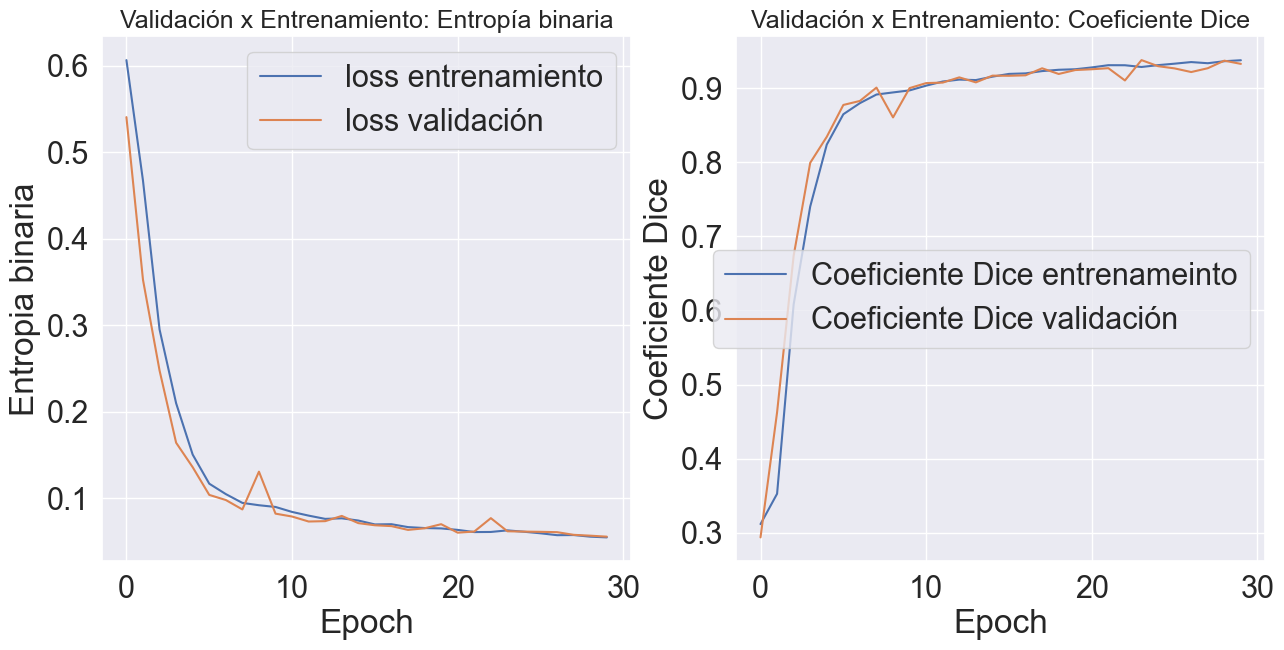

In [122]:
def get_metrics(history):
    fig = plt.figure(figsize = (15,15))
    plt.subplot(2,2,1)
    plt.plot(history.history["loss"], label = "loss entrenamiento")
    plt.plot(history.history["val_loss"], label = "loss validación")
    plt.title("Validación x Entrenamiento: Entropía binaria", fontsize=18, y=1)
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Entropia binaria")

    plt.subplot(2,2,2)
    plt.plot(history.history["dice_coef"], label = "Coeficiente Dice entrenameinto")
    plt.plot(history.history["val_dice_coef"], label = "Coeficiente Dice validación")
    plt.title("Validación x Entrenamiento: Coeficiente Dice", fontsize=18, y=1)
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Coeficiente Dice")
    
get_metrics(history = history)

### Comprobación de la validación de la prueba mediante el coeficiente Dice  
Utilizaremos los datos de la prueba para hacer nuestra predicción y realizaremos el solapamiento entre la máscara predicha y la real. Se examinarán 141 imágenes.

In [123]:
dice_coefs = list()
pred = model.predict(img_test)
pred[pred>=0.5] = 1
pred[pred<0.5] = 0
for i in tqdm(range(len(img_test))):
    prediction = pred[i]
    dice = dice_coef_test(y_true = mask_test[i], y_pred = prediction)
    dice_coefs.append(dice)

5/5 [==============================] - 2s 281ms/step


100%|██████████| 141/141 [00:00<00:00, 3377.89it/s]


Mediana Coef. Dice: 0.96276264591955


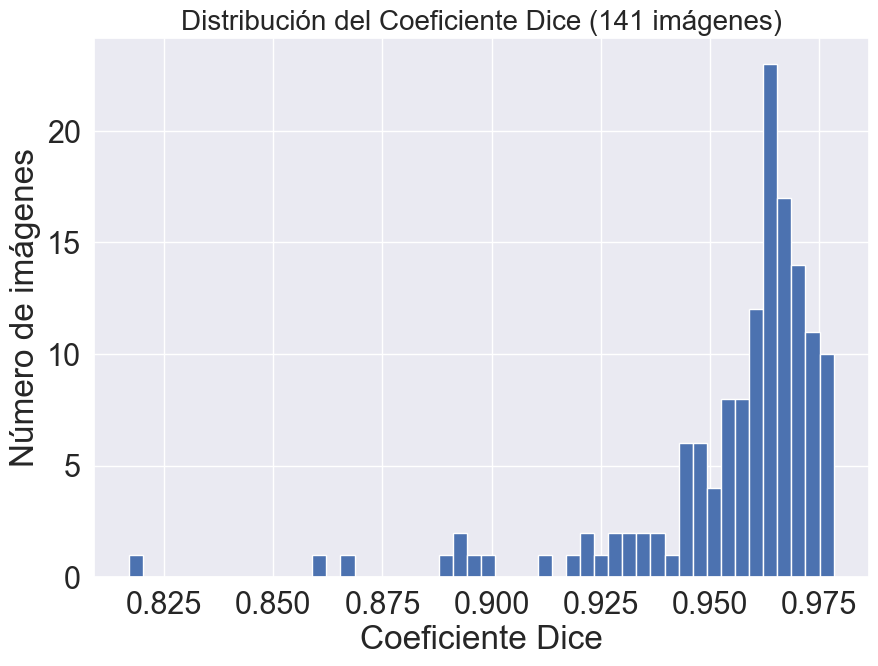

In [124]:
fig, ax = plt.subplots(figsize =(10, 7))
plt.hist(np.array(dice_coefs), bins = 50)
plt.title("Distribución del Coeficiente Dice (141 imágenes)",fontsize=20, y=1)
plt.xlabel("Coeficiente Dice");
plt.ylabel("Número de imágenes");
print(f'Mediana Coef. Dice: {np.median(np.array(dice_coefs))}');
plt.show()

Mediana Coef. Dice: 0.96276264591955


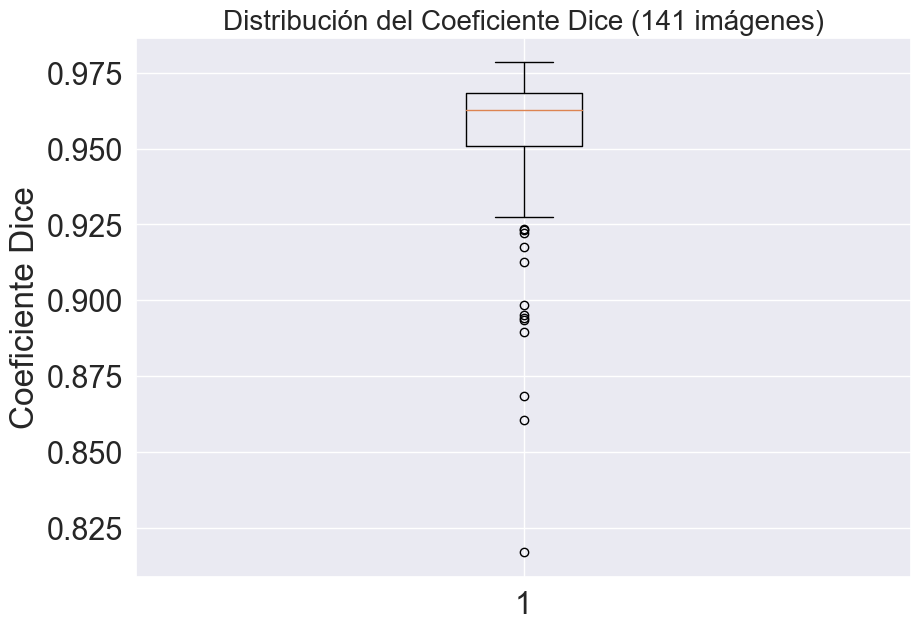

In [125]:
fig, ax = plt.subplots(figsize =(10, 7))
plt.boxplot(np.array(dice_coefs))
plt.title("Distribución del Coeficiente Dice (141 imágenes)",fontsize=20, y=1)
plt.ylabel("Coeficiente Dice");
print(f'Mediana Coef. Dice: {np.median(np.array(dice_coefs))}');
plt.show()

# Load pre-trained model

In [126]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from tqdm import tqdm # librería para monitorear las funciones y sus tiempos de ejecución.
import cv2 # Librería Open-CV para python.
from skimage import segmentation
import numpy as np
import tensorflow.keras.backend as K

In [128]:

def load_trained_model():
    try:
        K.set_floatx('float64')
        custom_objects = {'QuantumConv2D': QuantumConv2D, 'dice_coef': {}}
        model_path = './hybrid_classical_model_seg_local_Quantum_Decoder_30_epochs_v2.h5'
        model = load_model(model_path, custom_objects=custom_objects)
        print('Model loaded OK')
        return model

    except Exception as e:
        return {"error": "No se puede cargar el modelo: " + str(e)}


In [129]:
load_trained_model()

Model loaded OK


In [133]:
# Definir la función de predicción
def predict_image():
    # Cargar el modelo entrenado
    model = load_trained_model()
    if isinstance(model, dict):
        return model
    
    # Procesar la imagen
    img_side_size = 256
    img_path = './xr-lung-segmentation.jpeg'
    img = cv2.imread(img_path)
    if img is None:
        return {"error": f"No se pudo cargar la imagen: {img_path}"}
    img = cv2.resize(img, (img_side_size, img_side_size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_array = np.array(img, dtype=np.float32) / 255.0  # Normalizar la imagen
    
    # Verificar que la imagen tenga el tamaño correcto
    input_shape = model.input_shape[1:3]
    if img.shape[:2] != input_shape:
        return {"error": f"El tamaño de la imagen no coincide con el tamaño de entrada del modelo: {img.shape} vs {input_shape}"}
    
    # Realizar la predicción
    pred = model.predict(img_array.reshape(1,img_side_size,img_side_size,1))
    pred[pred>0.5] = 1.0
    pred[pred<0.5] = 0.0
    
    # Crear la figura de matplotlib
    fig = plt.figure(figsize=(15, 10))
    
    plt.subplot(1,3,1)
    plt.imshow(pred.reshape(img_side_size, img_side_size), cmap = "viridis")
    plt.title("Prediction")
    plt.axis("off")   
    
    plt.subplot(1,3,2)
    plt.imshow(img.reshape(img_side_size, img_side_size), cmap='gray')
    edges_est = segmentation.clear_border(np.squeeze(pred.reshape(img_side_size, img_side_size)))
    plt.contour(edges_est,[0.5],colors=['blue'])
    plt.title('Original Image')
    plt.axis('off')
    
    plt.savefig('./results.png', bbox_inches='tight', pad_inches=0)
    
    # Devolver los resultados
    return {"plot": fig}

In [134]:
def predict():
    results = []

    # Manejar errores si no se puede procesar la imagen
    try:
        result = predict_image()
    except Exception as e:
        return {"error": "No se puede procesar la imagen: " + str(e)}

    results.append(result)
    
    return {"results": results}

Model loaded OK
1/1 [==============================] - 0s 43ms/step


{'results': [{'plot': <Figure size 1500x1000 with 2 Axes>}]}

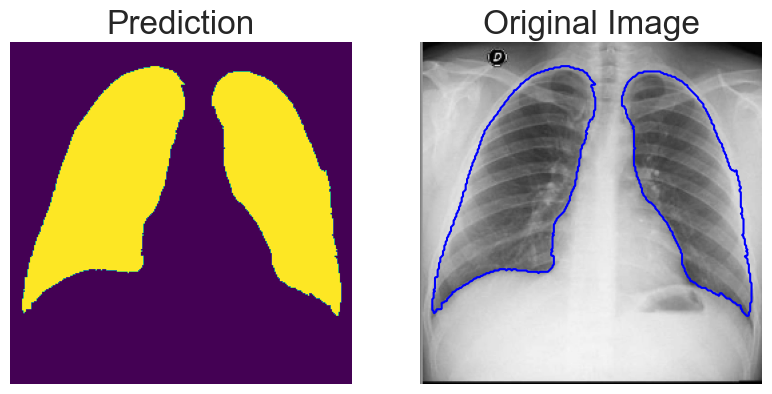

In [135]:
predict()